In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

In this jupyter notebook the impact of weather on foot traffic is analysed. First, some exemplary outliers are analysed,  
followed by a systematic analysis.

In [2]:
# read daily foot traffic data: ftraffic = foot traffic; ltr = pedestrians crossing from left to right;
# rtl = pedestrians crossing from right to left; dow = day of week; month = month; s_holid = school holidays
# p_holid = public holidays; br_mo = bridge day Monday; br_fr = bridge day Friday; bweek = black week; fest = city festivals
df = pd.read_csv('DATA/foottraffic_daily_schoenbornstr_prep.csv',parse_dates=['date'])
display(df.head())

,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest
0,2020-01-01,7285.0,NaN,NaN,Wednesday,January,1,1,0,0,0,0
1,2020-01-02,40406.0,NaN,NaN,Thursday,January,1,0,0,0,0,0
2,2020-01-03,41095.0,NaN,NaN,Friday,January,1,0,0,0,0,0
3,2020-01-04,42096.0,NaN,NaN,Saturday,January,1,0,0,0,0,0
4,2020-01-05,7847.0,NaN,NaN,Sunday,January,0,0,0,0,0,0


In [3]:
# merge foot traffic and weather data
dfs = df[(df['date'].dt.year >= 2022) & (df['date'].dt.year <= 2024)].reset_index(drop=True)
dfw = pd.read_csv('DATA/DWD/weather-data_05705_prep.csv',parse_dates=['date'])
dfm = dfs.merge(dfw, on='date', how='inner')
display(dfm.head())

,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
0,2022-01-01,5536.0,NaN,NaN,Saturday,January,1,1,0,0,0,0,12.7,4.8,2.292857,3.5,0.0,0,0.0,0.0
1,2022-01-02,6688.0,NaN,NaN,Sunday,January,1,0,0,0,0,0,11.8,3.0,4.592857,10.1,0.0,0,0.0,41.0
2,2022-01-03,27178.0,NaN,NaN,Monday,January,1,0,0,0,0,0,11.9,7.1,5.757143,8.6,6.1,9,0.0,0.0
3,2022-01-04,15441.0,NaN,NaN,Tuesday,January,1,0,0,0,0,0,10.8,4.3,4.335714,7.2,16.6,13,0.0,0.0
4,2022-01-05,29837.0,NaN,NaN,Wednesday,January,1,0,0,0,0,0,5.1,1.4,6.821429,9.8,0.0,0,0.0,92.0


In [4]:
# filter out December, public and summer holidays, bridge days etc.  
dfs = dfm[(dfm['date'].dt.year >= 2023) & (dfm['date'].dt.year <= 2024)].reset_index(drop=True)
dfhs = dfs[
(dfs["month"] != "December") &
(dfs["p_holid"] == 0) & 
(dfs["br_mo"] == 0) & 
(dfs["br_fr"] == 0) & 
(dfs["bweek"] == 0) & 
(dfs["fest"] == 0)].reset_index(drop=True)
display(dfhs.head())

,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
0,2023-01-02,31956.0,NaN,NaN,Monday,January,1,0,0,0,0,0,16.2,8.0,5.471429,10.2,0.0,0,0.0,109.0
1,2023-01-03,34016.0,NaN,NaN,Tuesday,January,1,0,0,0,0,0,9.0,3.6,2.528571,4.1,0.0,0,0.0,297.0
2,2023-01-04,28610.0,NaN,NaN,Wednesday,January,1,0,0,0,0,0,10.2,2.3,8.457143,11.4,0.6,4,0.0,0.0
3,2023-01-05,32743.0,NaN,NaN,Thursday,January,1,0,0,0,0,0,11.2,8.3,6.557143,8.7,0.0,0,0.0,49.0
4,2023-01-07,41935.0,NaN,NaN,Saturday,January,1,0,0,0,0,0,9.6,4.3,3.142857,4.9,0.0,0,0.0,36.0


# Exemplary Outliers

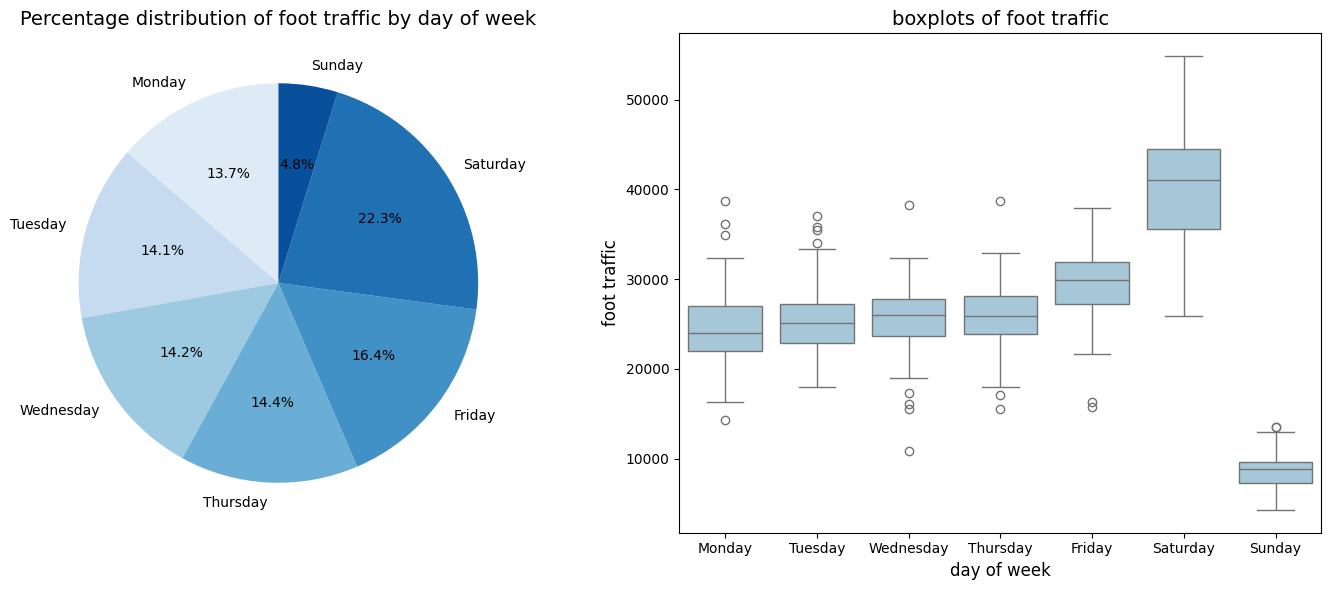

In [5]:
# foot traffic at different days of the week
dow_mean = dfhs.groupby('dow')['ftraffic'].mean().sort_index()
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_mean = dow_mean[week]

import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].pie(dow_mean.values, labels=dow_mean.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Blues", len(dow_mean)))
axes[0].set_title('Percentage distribution of foot traffic by day of week', fontsize=14)
blue = sns.color_palette("Blues", 7)[2]
sns.boxplot(x='dow', y='ftraffic', data=dfhs, order=week, ax=axes[1], color=blue)
axes[1].set_title('boxplots of foot traffic', fontsize=14)
axes[1].set_xlabel('day of week', fontsize=12)
axes[1].set_ylabel('foot traffic', fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
# Define function to display outlier days
def displ_outl(dfhs,day):
    dfd = dfhs[dfhs['dow'] == day]
    q1 = dfd['ftraffic'].quantile(0.25)
    q3 = dfd['ftraffic'].quantile(0.75)
    iqr = q3 - q1
    uw = q3 + 1.5 * iqr
    lw = q1-1.5*iqr
    dx = dfd[dfd['ftraffic'] > uw]
    dn = dfd[dfd['ftraffic'] < lw]
    print('upper outlier')
    if (len(dx))==0: # if there are no boxplot outliers, select the three highest values
        dx = dfd.nlargest(3, 'ftraffic')
    display(dx)
    print('#################')
    print('lower outlier')
    if (len(dn))==0: # if there are no boxplot outliers, select the three lowest values
        dn = dfd.nsmallest(3, 'ftraffic')
    display(dn)
    return()

In [7]:
# define function to plot time series of foot traffic and weather data
def plot_times(dfm,start,end,v1,v2,dow):
    dfs = dfm[(dfm['date'] >= start) & (dfm['date'] <= end)]
    dfs['Fgr'] = (dfs['s_holid'] != dfs['s_holid'].shift()).cumsum()
    fdata = dfs[dfs['s_holid'] == 1]
    fer_s = fdata.groupby('Fgr')['date'].min()
    fer_e = fdata.groupby('Fgr')['date'].max()
    fig, ax1 = plt.subplots(figsize=(10, 5))
    for start, end in zip(fer_s, fer_e):
        ax1.axvspan(start, end, color='gray', alpha=0.3)  # Ferien werden grau unterlegt
    ftag_days = dfs[dfs['p_holid'] == 1]['date']
    for day in ftag_days:
        ax1.axvspan(day - pd.Timedelta(days=0.2), day + pd.Timedelta(days=0.2), color='purple', alpha=0.5) # Feiertage werden violett unterlegt
    ax1.plot(dfs['date'], dfs['ftraffic'], label='foot traffic', color='k')
    ddata = dfs[dfs['dow'] == dow]
    ax1.scatter(ddata['date'], ddata['ftraffic'], color='k', zorder=20, s=60)
    ax1.set_xlabel('date')
    ax1.set_ylabel('foot traffic', color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    ax2 = ax1.twinx()
    if v1=='sd':
        ax2.plot(dfs['date'], dfs[v1]/60., label=v1, color='r')
    else:
        ax2.plot(dfs['date'], dfs[v1], label=v1, color='r')
    if v2=='sd':
        ax2.bar(dfs['date'], dfs[v2]/60., width=0.5, label=v2, color='c', alpha=0.6)
    else:
        ax2.bar(dfs['date'], dfs[v2], width=0.5, label=v2, color='c', alpha=0.6)
    ax2.set_ylabel(''+str(v1)+' / '+str(v2)+'', color='k')
    ax2.tick_params(axis='y', labelcolor='k')
    plt.title('timeseries foot traffic, '+str(v1)+' and '+str(v2)+'')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

In [8]:
day='Monday' # select day of week
displ_outl(dfhs,day)

upper outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
89,2023-04-03,34860.0,NaN,NaN,Monday,April,1,0,0,0,0,0,7.8,-0.8,6.035714,7.7,0.0,0,0.0,667.0
282,2023-10-30,38673.0,NaN,NaN,Monday,October,1,0,0,0,0,0,16.0,10.5,2.264286,3.9,0.7,2,0.0,262.0
588,2024-10-28,36086.0,17854.0,18232.0,Monday,October,1,0,0,0,0,0,19.3,8.6,1.621429,3.8,0.0,0,0.0,322.0


#################
lower outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
295,2023-11-13,14320.0,NaN,NaN,Monday,November,0,0,0,0,0,0,14.4,4.3,5.085714,11.4,13.2,14,0.0,0.0


()

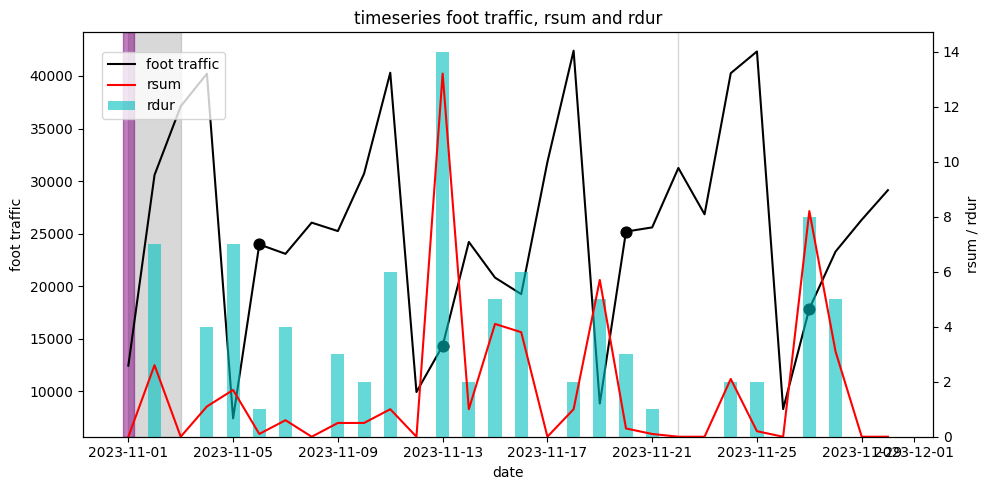

In [9]:
# time series plot to analyse foot traffic outliers
# 1.) period (use 2-3 weeks before and 2-3 weeks after outlier day) 
start,end='2023-11-01','2023-11-30'

# 2.) weather variables which are plotted on 2nd y-axis; please select TWO variables 
# Tmax=day max temperature, Tmin=day min temperature, wmean=men wind velocity (6-19UTC), wmax=max wind velocity (6-19UTC),
# rsum=accumulated rainfall (6-19UTC), rdur=rainfall duration [h] (6-19UTC), snow = accumulated snow (6-19UTC), sd=duration of sunshine (6-19UTC)
v1,v2='rsum','rdur'

# 3.) day of week that is indicated by black dots
dow='Monday'
plot_times(dfm,start,end,v1,v2,dow)

On Monday, 13th of November 2023, (see Figure above) we see much lower foot traffic when compared to the Mondays before and after. This is
probably due to very "bad" weather with strong continuos rainfall over 14 hours. Note that the grey shaded periods
represent summer holidays, while the purple bars represent public holidays.

In [10]:
day='Tuesday' # select day of week
displ_outl(dfhs,day)

upper outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
1,2023-01-03,34016.0,NaN,NaN,Tuesday,January,1,0,0,0,0,0,9.0,3.6,2.528571,4.1,0.0,0,0.0,297.0
140,2023-05-30,35451.0,NaN,NaN,Tuesday,May,1,0,0,0,0,0,23.4,11.5,4.371429,6.8,0.0,0,0.0,789.0
283,2023-10-31,37058.0,NaN,NaN,Tuesday,October,1,0,0,0,0,0,12.9,9.6,5.771429,8.2,0.0,0,0.0,27.0
589,2024-10-29,35856.0,17655.0,18201.0,Tuesday,October,1,0,0,0,0,0,18.2,8.6,1.321429,2.2,0.0,0,0.0,185.0


#################
lower outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
408,2024-04-16,18018.0,NaN,NaN,Tuesday,April,0,0,0,0,0,0,10.8,2.5,9.692857,14.7,6.8,5,0.0,339.0
278,2023-10-24,18214.0,NaN,NaN,Tuesday,October,0,0,0,0,0,0,12.3,8.2,1.700000,4.9,7.8,9,0.0,0.0
69,2023-03-14,18336.0,NaN,NaN,Tuesday,March,0,0,0,0,0,0,12.0,2.1,8.142857,13.1,2.7,5,0.0,70.0


()

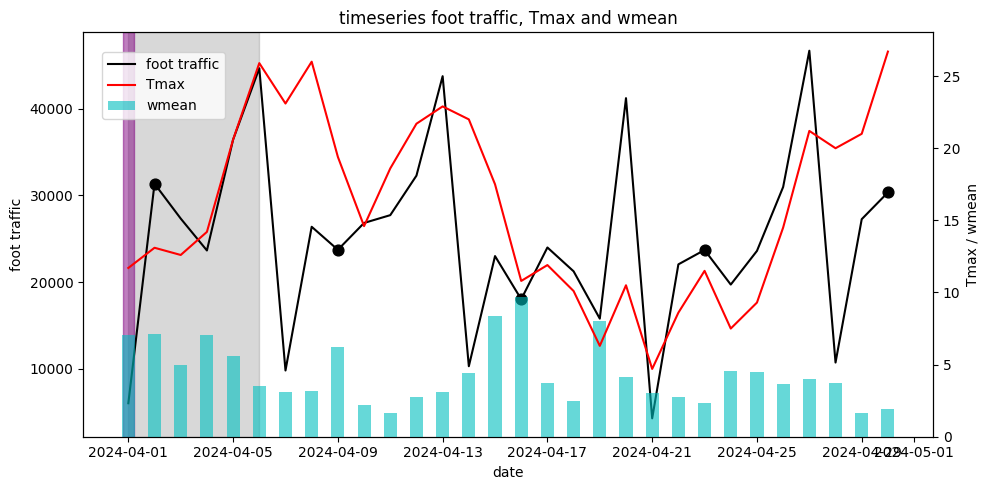

In [11]:
# time series plot to analyse foot traffic outliers
# 1.) period (use 2-3 weeks before and 2-3 weeks after outlier day) 
start,end='2024-04-01','2024-04-30'

# 2.) weather variables which are plotted on 2nd y-axis; please select TWO variables 
# Tmax=day max temperature, Tmin=day min temperature, wmean=men wind velocity (6-19UTC), wmax=max wind velocity (6-19UTC),
# rsum=accumulated rainfall (6-19UTC), rdur=rainfall duration [h] (6-19UTC), snow = accumulated snow (6-19UTC), sd=duration of sunshine (6-19UTC)
v1,v2='Tmax','wmean'

# 3.) day of week that is indicated by black dots
dow='Tuesday'
plot_times(dfm,start,end,v1,v2,dow)

On Tuesday, the 16th of April 2024, (see Figure above) we see lower foot traffic when compared to the Tuesdays before and after. This is probably
due to uncomfortable weather with a strong drop in temperature and windy conditions.

In [12]:
day='Wednesday' # select day of week
displ_outl(dfhs,day)

upper outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
590,2024-10-30,38225.0,19000.0,19225.0,Wednesday,October,1,0,0,0,0,0,11.2,7.2,1.292857,2.1,0.1,1,0.0,0.0


#################
lower outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
15,2023-01-18,17363.0,NaN,NaN,Wednesday,January,0,0,0,0,0,0,0.5,-6.1,2.757143,3.7,3.4,7,3.4,0.0
63,2023-03-08,15549.0,NaN,NaN,Wednesday,March,0,0,0,0,0,0,8.7,0.4,5.328571,8.7,7.2,11,0.6,0.0
321,2024-01-17,10827.0,NaN,NaN,Wednesday,January,0,0,0,0,0,0,0.9,-7.9,1.378571,2.5,6.5,8,6.5,0.0
342,2024-02-07,16046.0,NaN,NaN,Wednesday,February,0,0,0,0,0,0,9.5,2.9,8.814286,11.7,10.7,12,0.0,4.0


()

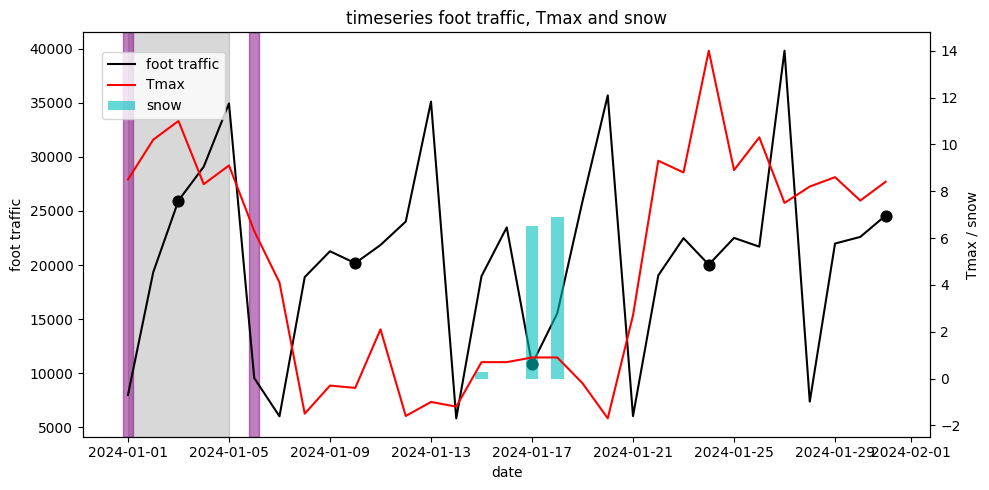

In [13]:
# time series plot to analyse foot traffic outliers
# 1.) period (use 2-3 weeks before and 2-3 weeks after outlier day) 
start,end='2024-01-01','2024-01-31'

# 2.) weather variables which are plotted on 2nd y-axis; please select TWO variables 
# Tmax=day max temperature, Tmin=day min temperature, wmean=men wind velocity (6-19UTC), wmax=max wind velocity (6-19UTC),
# rsum=accumulated rainfall (6-19UTC), rdur=rainfall duration [h] (6-19UTC), snow = accumulated snow (6-19UTC), sd=duration of sunshine (6-19UTC)
v1,v2='Tmax','snow'

# 3.) day of week that is indicated by black dots
dow='Wednesday'
plot_times(dfm,start,end,v1,v2,dow)

On Wednesday, the 17th of January 2024, (see Figure above) we see much lower foot traffic when compared to the Wednesdays before and after. This is probably
due to winter conditions with cold temperatures and heavy snow fall.

In [14]:
day='Saturday' # select day of week
displ_outl(dfhs,day)

upper outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
548,2024-09-14,54842.0,29575.0,25267.0,Saturday,September,0,0,0,0,0,0,16.4,8.0,3.457143,4.4,0.0,0,0.0,192.0
592,2024-11-02,53109.0,26627.0,26482.0,Saturday,November,0,0,0,0,0,0,12.6,5.8,1.364286,4.6,0.0,0,0.0,16.0
242,2023-09-16,48445.0,NaN,NaN,Saturday,September,0,0,0,0,0,0,29.3,12.9,2.085714,2.7,0.0,0,0.0,662.0


#################
lower outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
217,2023-08-19,25868.0,NaN,NaN,Saturday,August,1,0,0,0,0,0,35.0,17.4,2.864286,5.2,0.0,0,0.0,561.0
530,2024-08-24,28529.0,14132.0,14397.0,Saturday,August,1,0,0,0,0,0,33.2,14.5,4.407143,6.4,0.0,0,0.0,715.0
448,2024-06-01,29213.0,NaN,NaN,Saturday,June,1,0,0,0,0,0,18.3,12.9,3.528571,5.3,17.9,7,0.0,25.0


()

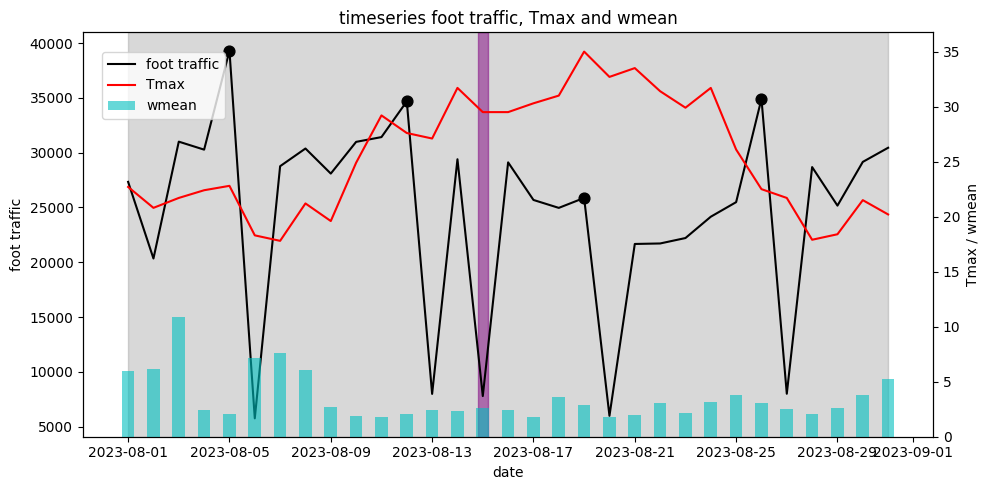

In [15]:
# time series plot to analyse foor traffic outliers
# 1.) period (use 2-3 weeks before and 2-3 weeks after outlier day) 
start,end='2023-08-01','2023-08-31'

# 2.) weather variables which are plotted on 2nd y-axis; please select TWO variables 
# Tmax=day max temperature, Tmin=day min temperature, wmean=men wind velocity (6-19UTC), wmax=max wind velocity (6-19UTC),
# rsum=accumulated rainfall (6-19UTC), rdur=rainfall duration [h] (6-19UTC), snow = accumulated snow (6-19UTC), sd=duration of sunshine (6-19UTC)
v1,v2='Tmax','wmean'

# 3.) day of week that is indicated by black dots
dow='Saturday'
plot_times(dfm,start,end,v1,v2,dow)

On Saturday, the 19th of August 2023, (see Figure above) we see much lower foot traffic when compared to the Saturdays before and after. This is probably due to severe heat with Tmax exceeding 35°C.

In [16]:
day='Sunday' # select day of week
displ_outl(dfhs,day)

upper outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
120,2023-05-07,13560.0,NaN,NaN,Sunday,May,0,0,0,0,0,0,23.6,11.5,3.642857,5.1,0.0,0,0.0,381.0
139,2023-05-28,13540.0,NaN,NaN,Sunday,May,0,0,0,0,0,0,24.7,9.0,2.464286,4.0,0.0,0,0.0,824.0


#################
lower outlier


,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
413,2024-04-21,4286.0,NaN,NaN,Sunday,April,0,0,0,0,0,0,4.7,0.7,3.057143,5.6,8.7,11,0.0,0.0
33,2023-02-05,4914.0,NaN,NaN,Sunday,February,0,0,0,0,0,0,0.3,-3.6,1.592857,3.5,2.6,6,2.6,0.0
12,2023-01-15,5379.0,NaN,NaN,Sunday,January,0,0,0,0,0,0,10.0,1.9,5.664286,8.4,6.4,9,0.0,90.0


()

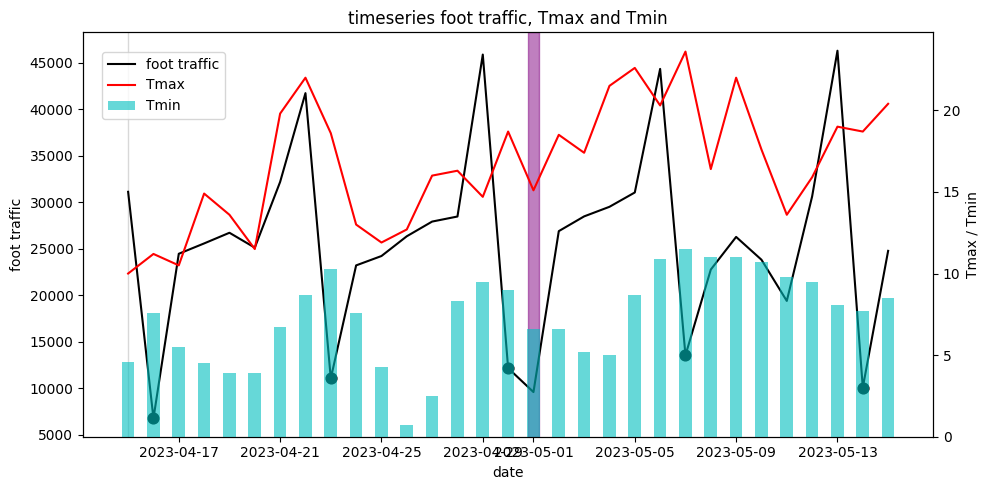

In [17]:
# time series plot to analyse foot traffic outliers
# 1.) period (use 2-3 weeks before and 2-3 weeks after outlier day) 
start,end='2023-04-15','2023-05-15'

# 2.) weather variables which are plotted on 2nd y-axis; please select TWO variables 
# Tmax=day max temperature, Tmin=day min temperature, wmean=men wind velocity (6-19UTC), wmax=max wind velocity (6-19UTC),
# rsum=accumulated rainfall (6-19UTC), rdur=rainfall duration [h] (6-19UTC), snow = accumulated snow (6-19UTC), sd=duration of sunshine (6-19UTC)
v1,v2='Tmax','Tmin'

# 3.) day of week that is indicated by black dots
dow='Sunday'
plot_times(dfm,start,end,v1,v2,dow)

On Sunday, the 07th of May 2023, (see Figure above) we see higher foot traffic when compared to the Sundays before and after. This is probably
due to the fact that this is the first Sunday of the year with warm conditions when Tmax (Tmin) exceeds 20°C (10°C).

In [ ]:
# Feel free to create your own time series plot.
# 1.) period (use 2-3 weeks before and 2-3 weeks after outlier day) 
start,end='YYYY-MM-DD','YYYY-MM-DD'

# 2.) weather variables which are plotted on 2nd y-axis; please select TWO variables 
# Tmax=day max temperature, Tmin=day min temperature, wmean=men wind velocity (6-19UTC), wmax=max wind velocity (6-19UTC),
# rsum=accumulated rainfall (6-19UTC), rdur=rainfall duration [h] (6-19UTC), snow = accumulated snow (6-19UTC), sd=duration of sunshine (6-19UTC)
v1,v2='Variable1','Variable2'

# 3.) day of week that is indicated by black dots
dow='Day of week'
plot_times(dfm,start,end,v1,v2,dow)

# Systematic Analysis

In [18]:
# filter out public holidays, bridge days, black week, etc.
dfs = dfm[(dfm['date'].dt.year >= 2023) & (dfm['date'].dt.year <= 2024)].reset_index(drop=True)
dfhs = dfs[
(dfs["p_holid"] == 0) & 
(dfs["br_mo"] == 0) & 
(dfs["br_fr"] == 0) & 
(dfs["bweek"] == 0) & 
(dfs["fest"] == 0)].reset_index(drop=True)
display(dfhs.head())

,date,ftraffic,ltr,rtl,dow,month,s_holid,p_holid,br_mo,br_fr,bweek,fest,Tmax,Tmin,wmean,wmax,rsum,rdur,snow,sd
0,2023-01-02,31956.0,NaN,NaN,Monday,January,1,0,0,0,0,0,16.2,8.0,5.471429,10.2,0.0,0,0.0,109.0
1,2023-01-03,34016.0,NaN,NaN,Tuesday,January,1,0,0,0,0,0,9.0,3.6,2.528571,4.1,0.0,0,0.0,297.0
2,2023-01-04,28610.0,NaN,NaN,Wednesday,January,1,0,0,0,0,0,10.2,2.3,8.457143,11.4,0.6,4,0.0,0.0
3,2023-01-05,32743.0,NaN,NaN,Thursday,January,1,0,0,0,0,0,11.2,8.3,6.557143,8.7,0.0,0,0.0,49.0
4,2023-01-07,41935.0,NaN,NaN,Saturday,January,1,0,0,0,0,0,9.6,4.3,3.142857,4.9,0.0,0,0.0,36.0


In [19]:
# compute daily foot traffic anomalies (ftraffic_a) and Tmax anomalies (tmax_a). The weekly course of
# foot traffic is considered by doing the anomaly computation for each day of week, individually.
dfs_l = []
for month in dfhs["month"].unique():
    dfa = dfhs[dfhs["month"] == month].copy()
    dowm = dfa.groupby("dow")["ftraffic"].mean()
    dfa["ftraffic_a"] = dfa.apply(lambda row: row["ftraffic"] - dowm[row["dow"]], axis=1)
    tmax_mean = dfa["Tmax"].mean(skipna=True)
    dfa["tmax_a"] = dfa["Tmax"] - tmax_mean
    dfs_l.append(dfa[['month','ftraffic_a','tmax_a','rsum','rdur','snow']])
dfs=pd.concat(dfs_l, ignore_index=True)
display(dfs.head())

,month,ftraffic_a,tmax_a,rsum,rdur,snow
0,January,10519.111111,11.101724,0.0,0,0.0
1,January,10945.400000,3.901724,0.0,0,0.0
2,January,7798.555556,5.101724,0.6,4,0.0
3,January,9571.750000,6.101724,0.0,0,0.0
4,January,5410.000000,4.501724,0.0,0,0.0


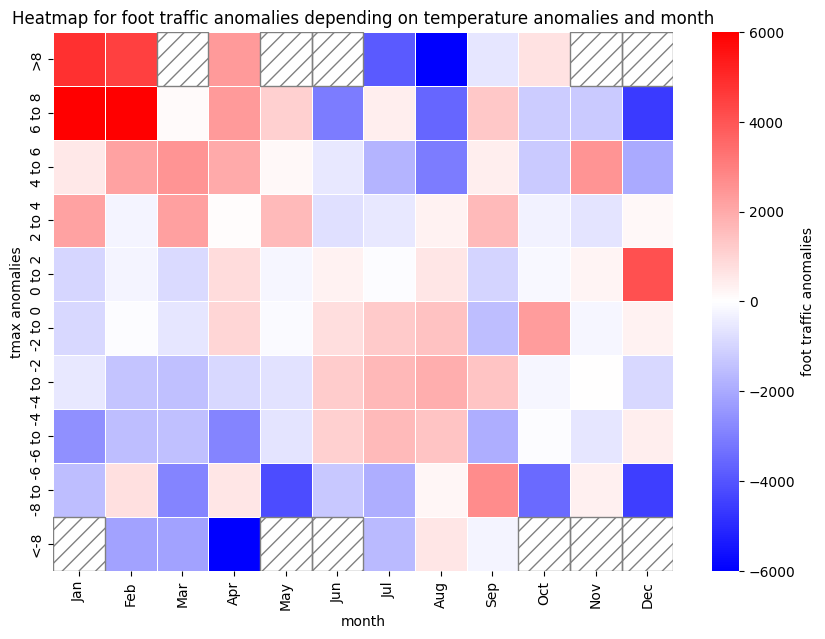

In [20]:
# display heat map for foot traffic anomalies by month and tmax anomalies
bins = [-np.inf, -8, -6, -4, -2, 0, 2, 4, 6, 8, np.inf]
labels = ["<-8", "-8 to -6", "-6 to -4", "-4 to -2", "-2 to 0", "0 to 2", "2 to 4", "4 to 6", "6 to 8", ">8"]
xlabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mo = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
dfs['month'] = pd.Categorical(dfs['month'], categories=mo, ordered=True)
dfs['tmax_b'] = pd.cut(dfs['tmax_a'], bins=bins, labels=labels)
pdata = dfs.groupby(['tmax_b', 'month'])['ftraffic_a'].mean().unstack()
nan_mask = pdata.isna()
plt.figure(figsize=(10, 7))
sns.heatmap(pdata, cmap="bwr", annot=False, cbar_kws={'label': 'foot traffic anomalies'}, linewidths=0.5, vmin=-6000, vmax=6000)
for i in range(nan_mask.shape[0]):
    for j in range(nan_mask.shape[1]):
        if nan_mask.iloc[i, j]:
            plt.gca().add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='grey', hatch='//', lw=1))
plt.gca().invert_yaxis()
plt.title('Heatmap for foot traffic anomalies depending on temperature anomalies and month')
plt.xlabel('month')
x_ticks = np.arange(len(xlabels)) + 0.5
plt.xticks(ticks=x_ticks, labels=xlabels)
plt.ylabel('tmax anomalies')
plt.show()

From the Figure above we see that the impact of temperature anomalies on foot traffic depends on the season. For example, in
January and February much warmer than normal conditions (>+6°C) are associated with positive foot traffic anomalies, while in summer
the foot traffic strongly decreases with increasing tmax anomalies. For summer, optimal conditions for the pedestrians seem to be slightly to
moderately lower than normal temperatures (0 to -6°C), while for January to May foot traffic generally benefits from tmax anomalies of
more than +2°C.

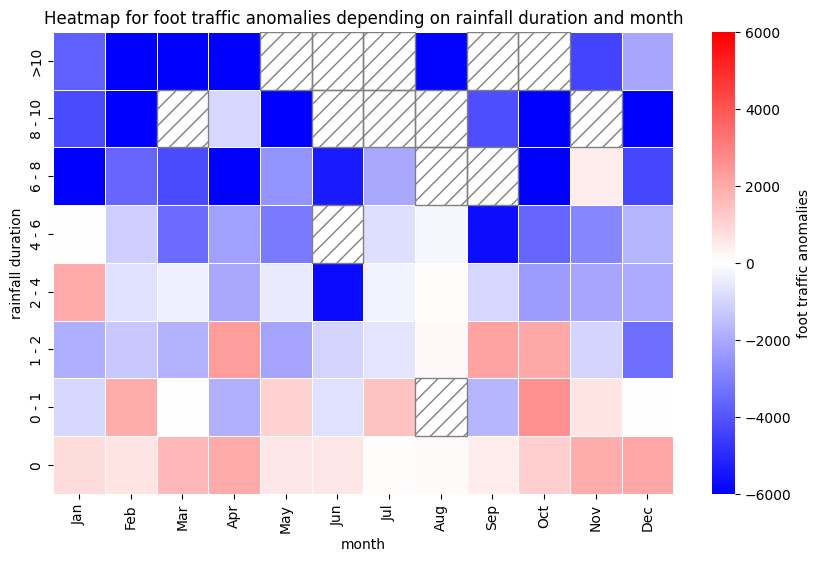

In [21]:
# display heat maps for foot traffic anomalies by month and rainfall duration
bins = [-np.inf, 0, 1, 2, 4, 6, 8, 10, np.inf]
labels = ["0", "0 - 1", "1 - 2", "2 - 4", "4 - 6", "6 - 8", "8 - 10" , ">10"]
xlabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#mo = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
#dfs['month'] = pd.Categorical(dfs['month'], categories=mo, ordered=True)
dfs['rdur_b'] = pd.cut(dfs['rdur'], bins=bins,right=True, labels=labels)
pdata = dfs.groupby(['rdur_b', 'month'])['ftraffic_a'].mean().unstack()
nan_mask = pdata.isna()
plt.figure(figsize=(10, 6))
sns.heatmap(pdata, cmap="bwr", annot=False, cbar_kws={'label': 'foot traffic anomalies'}, linewidths=0.5, vmin=-6000, vmax=6000)
for i in range(nan_mask.shape[0]):
    for j in range(nan_mask.shape[1]):
        if nan_mask.iloc[i, j]:
            plt.gca().add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='grey', hatch='//', lw=1))
plt.gca().invert_yaxis()
plt.title('Heatmap for foot traffic anomalies depending on rainfall duration and month')
plt.xlabel('month')
x_ticks = np.arange(len(xlabels)) + 0.5
plt.xticks(ticks=x_ticks, labels=xlabels)
plt.ylabel('rainfall duration')
plt.show()

From the Figure above we see that contineous rainfall of more than 6 hours (in time period 6-19UTC) lead to a strong
reduction of foot traffic throughout the year. However, foot traffic benefits from dry conditions (rainfall duration = 0)
in Winter, Autumn, and Spring rather than in July and August.  

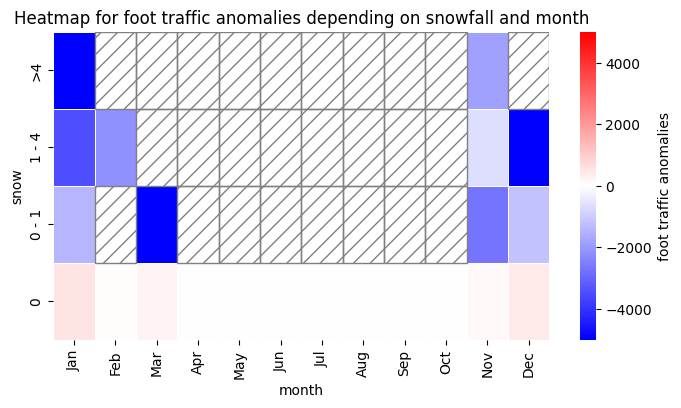

In [22]:
# display heat maps for foot traffic anomalies by month and snowfall
bins = [-np.inf, 0, 1, 4, np.inf]
labels = ["0", "0 - 1", "1 - 4", ">4"]
xlabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#mo = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
#dfs['month'] = pd.Categorical(dfs['month'], categories=mo, ordered=True)
dfs['snow_b'] = pd.cut(dfs['snow'], bins=bins,right=True, labels=labels)
pdata = dfs.groupby(['snow_b', 'month'])['ftraffic_a'].mean().unstack()
nan_mask = pdata.isna()
plt.figure(figsize=(8, 4))
sns.heatmap(pdata, cmap="bwr", annot=False, cbar_kws={'label': 'foot traffic anomalies'}, linewidths=0.5, vmin=-5000, vmax=5000)
for i in range(nan_mask.shape[0]):
    for j in range(nan_mask.shape[1]):
        if nan_mask.iloc[i, j]:
            plt.gca().add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='grey', hatch='//', lw=1))
plt.gca().invert_yaxis()
plt.title('Heatmap for foot traffic anomalies depending on snowfall and month')
plt.xlabel('month')
x_ticks = np.arange(len(xlabels)) + 0.5
plt.xticks(ticks=x_ticks, labels=xlabels)
plt.ylabel('snow')
plt.show()

From the Figure above we see that snow is generally associated with lower foot traffic.
Interestingly, even light snowfall (0-1 cm) is sufficient to significantly reduce foot traffic.